# Protocol Selection of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_resize_LC25000.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:3")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=3)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

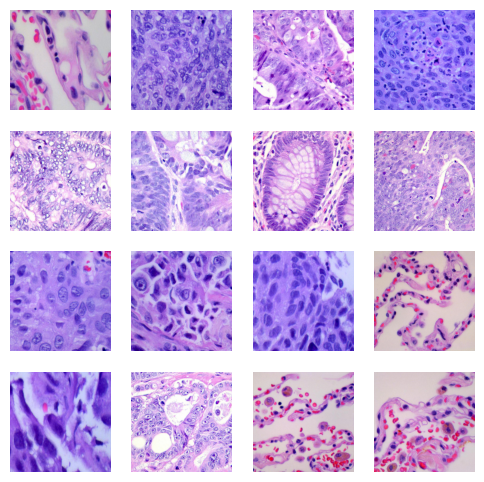

| It: 1 | Loss: 7.5520 | Time:   4.90s |


| It: 1001 | Loss: -60.0555 | Time: 438.16s |


| It: 2001 | Loss: -60.9801 | Time: 600.25s |


| It: 3001 | Loss: -61.2828 | Time: 601.18s |


| It: 4001 | Loss: -61.4551 | Time: 599.65s |


| It: 5001 | Loss: -61.5660 | Time: 599.17s |


| It: 6001 | Loss: -61.6349 | Time: 600.02s |


| It: 7001 | Loss: -61.6868 | Time: 599.75s |


| It: 8001 | Loss: -61.7204 | Time: 599.88s |


| It: 9001 | Loss: -61.7384 | Time: 598.12s |


| It: 1 | Loss: -0.7461 | Time:   0.67s |


| It: 1001 | Loss: -59.9223 | Time: 601.87s |


| It: 2001 | Loss: -60.9172 | Time: 601.79s |


| It: 3001 | Loss: -61.2988 | Time: 595.69s |


| It: 4001 | Loss: -61.4725 | Time: 597.01s |


| It: 5001 | Loss: -61.5729 | Time: 597.90s |


| It: 6001 | Loss: -61.6500 | Time: 598.38s |


| It: 7001 | Loss: -61.6998 | Time: 602.11s |


| It: 8001 | Loss: -61.7336 | Time: 602.65s |


| It: 9001 | Loss: -61.7506 | Time: 600.41s |


| It: 1 | Loss: -3.9135 | Time:   0.67s |


| It: 1001 | Loss: -59.6657 | Time: 600.09s |


| It: 2001 | Loss: -60.6722 | Time: 596.38s |


| It: 3001 | Loss: -61.1028 | Time: 599.93s |


| It: 4001 | Loss: -61.3311 | Time: 602.43s |


| It: 5001 | Loss: -61.4783 | Time: 599.79s |


| It: 6001 | Loss: -61.5733 | Time: 600.69s |


| It: 7001 | Loss: -61.6394 | Time: 599.89s |


| It: 8001 | Loss: -61.6801 | Time: 597.33s |


| It: 9001 | Loss: -61.7009 | Time: 601.79s |


| It: 1 | Loss: -31.8296 | Time:   0.66s |


| It: 1001 | Loss: -60.5492 | Time: 600.77s |


| It: 2001 | Loss: -61.1868 | Time: 597.06s |


| It: 3001 | Loss: -61.3898 | Time: 601.76s |


| It: 4001 | Loss: -61.5052 | Time: 601.95s |


| It: 5001 | Loss: -61.5939 | Time: 596.81s |


| It: 6001 | Loss: -61.6618 | Time: 602.11s |


| It: 7001 | Loss: -61.7084 | Time: 601.15s |


| It: 8001 | Loss: -61.7405 | Time: 602.55s |


| It: 9001 | Loss: -61.7570 | Time: 600.48s |


| It: 1 | Loss: 1.0137 | Time:   0.66s |


| It: 1001 | Loss: -59.8290 | Time: 602.29s |


| It: 2001 | Loss: -60.8138 | Time: 596.04s |


| It: 3001 | Loss: -61.2033 | Time: 600.98s |


| It: 4001 | Loss: -61.3858 | Time: 593.64s |


| It: 5001 | Loss: -61.5132 | Time: 601.43s |


| It: 6001 | Loss: -61.5984 | Time: 599.45s |


| It: 7001 | Loss: -61.6654 | Time: 600.45s |


| It: 8001 | Loss: -61.7034 | Time: 599.69s |


| It: 9001 | Loss: -61.7233 | Time: 600.64s |


BEST PSNR: 13.7009
MEDIAN PSNR: 12.1154
ALL PSNR: [12.5730, 13.7009, 9.7514, 13.2907, 13.2907]


<Figure size 400x300 with 0 Axes>

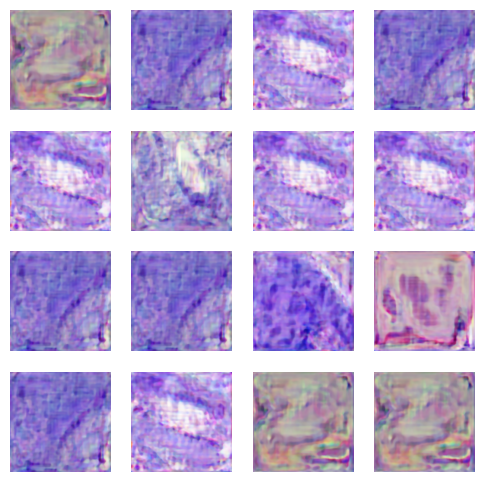

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

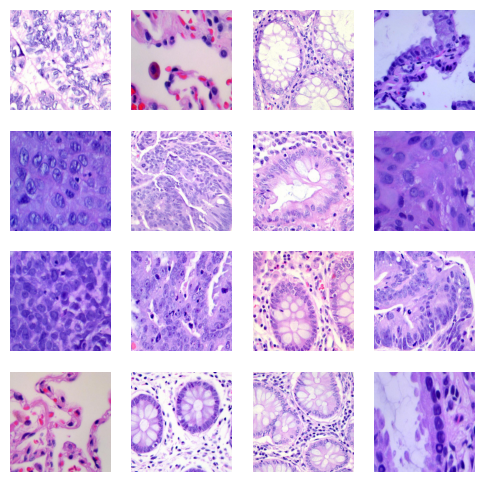

| It: 1 | Loss: -3.4130 | Time:   0.67s |


| It: 1001 | Loss: -59.5406 | Time: 521.95s |


| It: 2001 | Loss: -60.6058 | Time: 349.92s |


| It: 3001 | Loss: -61.0761 | Time: 355.61s |


| It: 4001 | Loss: -61.2980 | Time: 357.05s |


| It: 5001 | Loss: -61.4450 | Time: 356.19s |


| It: 6001 | Loss: -61.5413 | Time: 356.59s |


| It: 7001 | Loss: -61.6099 | Time: 352.29s |


| It: 8001 | Loss: -61.6598 | Time: 357.03s |


| It: 9001 | Loss: -61.6833 | Time: 357.07s |


| It: 1 | Loss: -29.0834 | Time:   0.36s |


| It: 1001 | Loss: -59.6823 | Time: 356.90s |


| It: 2001 | Loss: -60.7754 | Time: 356.31s |


| It: 3001 | Loss: -61.1886 | Time: 356.67s |


| It: 4001 | Loss: -61.3546 | Time: 356.17s |


| It: 5001 | Loss: -61.4843 | Time: 354.73s |


| It: 6001 | Loss: -61.5758 | Time: 355.08s |


| It: 7001 | Loss: -61.6396 | Time: 355.56s |


| It: 8001 | Loss: -61.6798 | Time: 350.78s |


| It: 9001 | Loss: -61.7003 | Time: 354.46s |


| It: 1 | Loss: -10.2720 | Time:   0.36s |


| It: 1001 | Loss: -59.5741 | Time: 349.53s |


| It: 2001 | Loss: -60.7264 | Time: 355.73s |


| It: 3001 | Loss: -61.1417 | Time: 356.22s |


| It: 4001 | Loss: -61.2987 | Time: 356.82s |


| It: 5001 | Loss: -61.4437 | Time: 356.62s |


| It: 6001 | Loss: -61.5277 | Time: 356.75s |


| It: 7001 | Loss: -61.6013 | Time: 350.56s |


| It: 8001 | Loss: -61.6444 | Time: 357.47s |


| It: 9001 | Loss: -61.6657 | Time: 356.36s |


| It: 1 | Loss: -32.8311 | Time:   0.36s |


| It: 1001 | Loss: -59.4434 | Time: 355.87s |


| It: 2001 | Loss: -60.6298 | Time: 356.96s |


| It: 3001 | Loss: -61.0962 | Time: 356.48s |


| It: 4001 | Loss: -61.3255 | Time: 356.08s |


| It: 5001 | Loss: -61.4561 | Time: 358.32s |


| It: 6001 | Loss: -61.5537 | Time: 358.51s |


| It: 7001 | Loss: -61.6210 | Time: 354.81s |


| It: 8001 | Loss: -61.6616 | Time: 356.96s |


| It: 9001 | Loss: -61.6845 | Time: 357.23s |


| It: 1 | Loss: -10.6329 | Time:   0.37s |


| It: 1001 | Loss: -59.3876 | Time: 356.74s |


| It: 2001 | Loss: -60.4738 | Time: 349.44s |


| It: 3001 | Loss: -60.9464 | Time: 355.42s |


| It: 4001 | Loss: -61.1801 | Time: 356.63s |


| It: 5001 | Loss: -61.3516 | Time: 349.53s |


| It: 6001 | Loss: -61.4583 | Time: 356.79s |


| It: 7001 | Loss: -61.5409 | Time: 352.12s |


| It: 8001 | Loss: -61.5918 | Time: 355.60s |


| It: 9001 | Loss: -61.6181 | Time: 356.29s |


BEST PSNR: 13.1161
MEDIAN PSNR: 12.4975
ALL PSNR: [11.3705, 12.8170, 13.1161, 12.5378, 12.5378]


<Figure size 400x300 with 0 Axes>

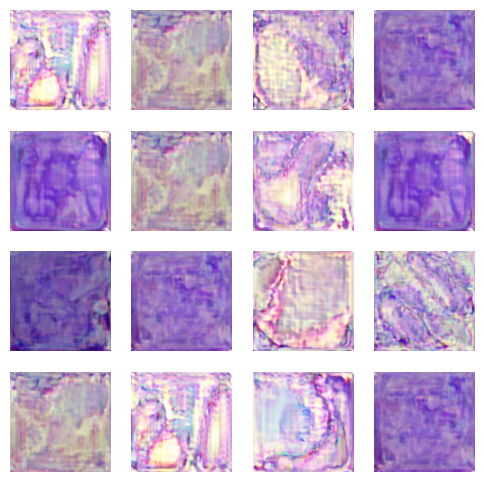

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

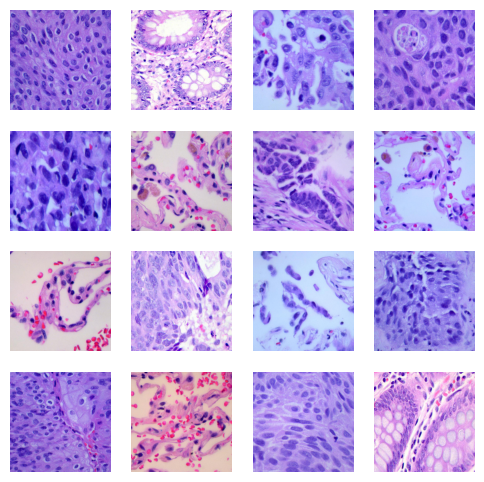

| It: 1 | Loss: -5.7861 | Time:   0.36s |


| It: 1001 | Loss: -59.6503 | Time: 353.50s |


| It: 2001 | Loss: -60.7506 | Time: 357.02s |


| It: 3001 | Loss: -61.1323 | Time: 357.86s |


| It: 4001 | Loss: -61.3493 | Time: 356.34s |


| It: 5001 | Loss: -61.4579 | Time: 355.55s |


| It: 6001 | Loss: -61.5392 | Time: 354.44s |


| It: 7001 | Loss: -61.6074 | Time: 353.53s |


| It: 8001 | Loss: -61.6501 | Time: 350.74s |


| It: 9001 | Loss: -61.6710 | Time: 356.00s |


| It: 1 | Loss: 1.6966 | Time:   0.35s |


| It: 1001 | Loss: -59.0727 | Time: 356.37s |


| It: 2001 | Loss: -60.5221 | Time: 356.10s |


| It: 3001 | Loss: -60.9865 | Time: 355.97s |


| It: 4001 | Loss: -61.2203 | Time: 350.26s |


| It: 5001 | Loss: -61.3627 | Time: 357.11s |


| It: 6001 | Loss: -61.4624 | Time: 357.02s |


| It: 7001 | Loss: -61.5442 | Time: 356.03s |


| It: 8001 | Loss: -61.5914 | Time: 356.12s |


| It: 9001 | Loss: -61.6178 | Time: 355.70s |


| It: 1 | Loss: -2.7680 | Time:   0.35s |


| It: 1001 | Loss: -59.8483 | Time: 356.47s |


| It: 2001 | Loss: -60.8300 | Time: 357.13s |


| It: 3001 | Loss: -61.1847 | Time: 356.43s |


| It: 4001 | Loss: -61.3430 | Time: 357.27s |


| It: 5001 | Loss: -61.4756 | Time: 354.89s |


| It: 6001 | Loss: -61.5508 | Time: 355.86s |


| It: 7001 | Loss: -61.6132 | Time: 352.39s |


| It: 8001 | Loss: -61.6518 | Time: 357.03s |


| It: 9001 | Loss: -61.6726 | Time: 341.77s |


| It: 1 | Loss: -24.0200 | Time:   0.35s |


| It: 1001 | Loss: -59.7395 | Time: 357.42s |


| It: 2001 | Loss: -60.8887 | Time: 357.65s |


| It: 3001 | Loss: -61.1918 | Time: 358.34s |


| It: 4001 | Loss: -61.3673 | Time: 358.31s |


| It: 5001 | Loss: -61.4779 | Time: 355.25s |


| It: 6001 | Loss: -61.5605 | Time: 357.86s |


| It: 7001 | Loss: -61.6187 | Time: 357.48s |


| It: 8001 | Loss: -61.6589 | Time: 358.13s |


| It: 9001 | Loss: -61.6784 | Time: 357.51s |


| It: 1 | Loss: -21.9192 | Time:   0.36s |


| It: 1001 | Loss: -59.9602 | Time: 348.99s |


| It: 2001 | Loss: -60.9248 | Time: 358.58s |


| It: 3001 | Loss: -61.2142 | Time: 357.47s |


| It: 4001 | Loss: -61.3825 | Time: 357.45s |


| It: 5001 | Loss: -61.4786 | Time: 357.69s |


| It: 6001 | Loss: -61.5583 | Time: 351.96s |


| It: 7001 | Loss: -61.6215 | Time: 359.03s |


| It: 8001 | Loss: -61.6608 | Time: 360.80s |


| It: 9001 | Loss: -61.6807 | Time: 359.01s |


BEST PSNR: 13.1237
MEDIAN PSNR: 12.1604
ALL PSNR: [10.8113, 13.1237, 12.5828, 12.4224, 12.4224]


<Figure size 400x300 with 0 Axes>

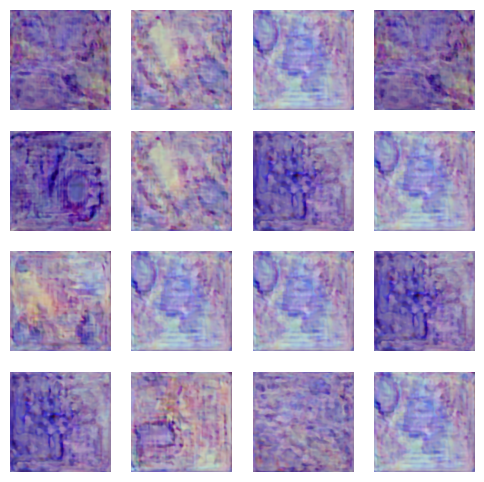

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

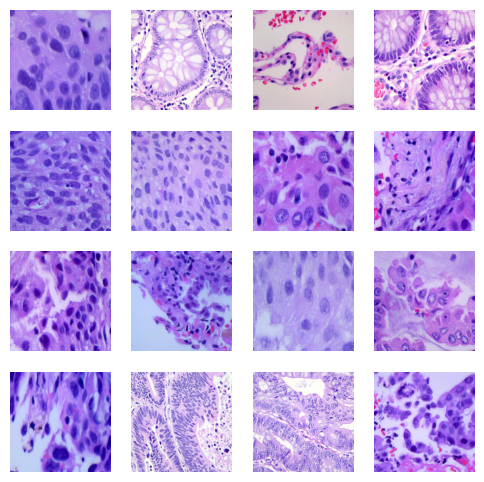

| It: 1 | Loss: -12.2736 | Time:   0.36s |


| It: 1001 | Loss: -60.1078 | Time: 359.63s |


| It: 2001 | Loss: -60.9143 | Time: 362.51s |


| It: 3001 | Loss: -61.3015 | Time: 364.50s |


| It: 4001 | Loss: -61.4937 | Time: 364.18s |


| It: 5001 | Loss: -61.5959 | Time: 362.22s |


| It: 6001 | Loss: -61.6637 | Time: 360.88s |


| It: 7001 | Loss: -61.7143 | Time: 359.47s |


| It: 8001 | Loss: -61.7445 | Time: 363.30s |


| It: 9001 | Loss: -61.7601 | Time: 365.29s |


| It: 1 | Loss: -0.2389 | Time:   0.36s |


| It: 1001 | Loss: -60.2149 | Time: 363.57s |


| It: 2001 | Loss: -61.1299 | Time: 361.80s |


| It: 3001 | Loss: -61.4391 | Time: 362.29s |


| It: 4001 | Loss: -61.5712 | Time: 365.49s |


| It: 5001 | Loss: -61.6458 | Time: 433.27s |


| It: 6001 | Loss: -61.7041 | Time: 469.34s |


| It: 7001 | Loss: -61.7465 | Time: 468.85s |


| It: 8001 | Loss: -61.7719 | Time: 470.26s |


| It: 9001 | Loss: -61.7852 | Time: 469.57s |


| It: 1 | Loss: -1.3994 | Time:   0.46s |


| It: 1001 | Loss: -60.2972 | Time: 468.17s |


| It: 2001 | Loss: -61.2388 | Time: 469.74s |


| It: 3001 | Loss: -61.4840 | Time: 469.13s |


| It: 4001 | Loss: -61.5966 | Time: 468.10s |


| It: 5001 | Loss: -61.6636 | Time: 468.92s |


| It: 6001 | Loss: -61.7163 | Time: 468.90s |


| It: 7001 | Loss: -61.7537 | Time: 468.43s |


| It: 8001 | Loss: -61.7773 | Time: 470.57s |


| It: 9001 | Loss: -61.7899 | Time: 470.17s |


| It: 1 | Loss: -3.9209 | Time:   0.48s |


| It: 1001 | Loss: -60.6460 | Time: 469.79s |


| It: 2001 | Loss: -61.2525 | Time: 467.77s |


| It: 3001 | Loss: -61.4863 | Time: 467.27s |


| It: 4001 | Loss: -61.5990 | Time: 468.35s |


| It: 5001 | Loss: -61.6636 | Time: 467.85s |


| It: 6001 | Loss: -61.7218 | Time: 468.34s |


| It: 7001 | Loss: -61.7607 | Time: 469.52s |


| It: 8001 | Loss: -61.7845 | Time: 466.75s |


| It: 9001 | Loss: -61.7975 | Time: 469.59s |


| It: 1 | Loss: -26.6910 | Time:   0.51s |


| It: 1001 | Loss: -60.0326 | Time: 469.48s |


| It: 2001 | Loss: -60.8806 | Time: 512.19s |


| It: 3001 | Loss: -61.2442 | Time: 568.87s |


| It: 4001 | Loss: -61.4319 | Time: 568.72s |


| It: 5001 | Loss: -61.5459 | Time: 571.60s |


| It: 6001 | Loss: -61.6220 | Time: 568.32s |


| It: 7001 | Loss: -61.6763 | Time: 571.03s |


| It: 8001 | Loss: -61.7103 | Time: 569.78s |


| It: 9001 | Loss: -61.7284 | Time: 571.18s |


BEST PSNR: 13.6256
MEDIAN PSNR: 13.1810
ALL PSNR: [13.6256, 12.7420, 13.1195, 13.0206, 13.0206]


<Figure size 400x300 with 0 Axes>

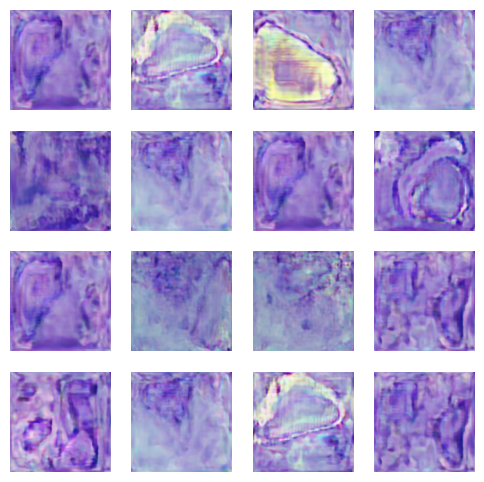

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

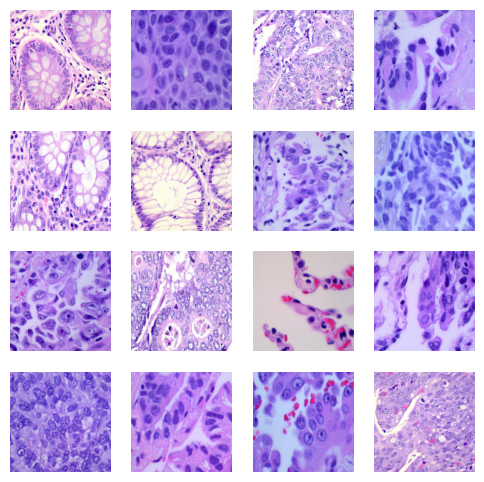

| It: 1 | Loss: -3.3529 | Time:   0.65s |


| It: 1001 | Loss: -60.6570 | Time: 571.88s |


| It: 2001 | Loss: -61.2022 | Time: 571.29s |


| It: 3001 | Loss: -61.4428 | Time: 569.91s |


| It: 4001 | Loss: -61.5824 | Time: 570.49s |


| It: 5001 | Loss: -61.6770 | Time: 571.11s |


| It: 6001 | Loss: -61.7313 | Time: 570.63s |


| It: 7001 | Loss: -61.7724 | Time: 570.85s |


| It: 8001 | Loss: -61.7981 | Time: 569.64s |


| It: 9001 | Loss: -61.8108 | Time: 568.93s |


| It: 1 | Loss: -11.0109 | Time:   0.56s |


| It: 1001 | Loss: -60.8017 | Time: 570.21s |


| It: 2001 | Loss: -61.2051 | Time: 571.96s |


| It: 3001 | Loss: -61.4103 | Time: 569.07s |


| It: 4001 | Loss: -61.5593 | Time: 571.43s |


| It: 5001 | Loss: -61.6509 | Time: 570.92s |


| It: 6001 | Loss: -61.7105 | Time: 571.75s |


| It: 7001 | Loss: -61.7555 | Time: 568.78s |


| It: 8001 | Loss: -61.7847 | Time: 569.15s |


| It: 9001 | Loss: -61.7990 | Time: 570.19s |


| It: 1 | Loss: -37.2673 | Time:   0.60s |


| It: 1001 | Loss: -60.5183 | Time: 570.29s |


| It: 2001 | Loss: -61.2029 | Time: 571.87s |


| It: 3001 | Loss: -61.4705 | Time: 570.16s |


| It: 4001 | Loss: -61.5934 | Time: 571.19s |


| It: 5001 | Loss: -61.6798 | Time: 570.99s |


| It: 6001 | Loss: -61.7357 | Time: 571.30s |


| It: 7001 | Loss: -61.7769 | Time: 570.16s |


| It: 8001 | Loss: -61.8021 | Time: 569.24s |


| It: 9001 | Loss: -61.8157 | Time: 567.20s |


| It: 1 | Loss: -2.7474 | Time:   0.72s |


| It: 1001 | Loss: -60.8220 | Time: 569.09s |


| It: 2001 | Loss: -61.3329 | Time: 565.79s |


| It: 3001 | Loss: -61.5280 | Time: 567.83s |


| It: 4001 | Loss: -61.6322 | Time: 568.46s |


| It: 5001 | Loss: -61.7044 | Time: 567.91s |


| It: 6001 | Loss: -61.7529 | Time: 569.55s |


| It: 7001 | Loss: -61.7898 | Time: 567.40s |


| It: 8001 | Loss: -61.8140 | Time: 565.56s |


| It: 9001 | Loss: -61.8261 | Time: 569.01s |


| It: 1 | Loss: -37.5168 | Time:   0.55s |


| It: 1001 | Loss: -60.7194 | Time: 567.60s |


| It: 2001 | Loss: -61.2301 | Time: 568.10s |


| It: 3001 | Loss: -61.4668 | Time: 567.11s |


| It: 4001 | Loss: -61.6063 | Time: 564.89s |


| It: 5001 | Loss: -61.6872 | Time: 568.54s |


| It: 6001 | Loss: -61.7431 | Time: 568.13s |


| It: 7001 | Loss: -61.7802 | Time: 567.17s |


| It: 8001 | Loss: -61.8040 | Time: 568.38s |


| It: 9001 | Loss: -61.8166 | Time: 568.23s |


BEST PSNR: 13.0595
MEDIAN PSNR: 12.6191
ALL PSNR: [12.2883, 13.0595, 12.3535, 12.9935, 12.9935]


<Figure size 400x300 with 0 Axes>

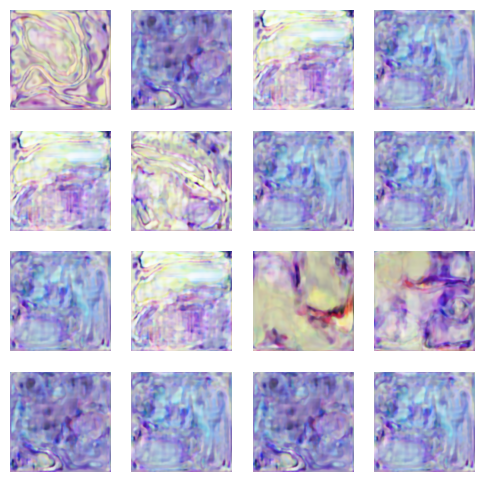

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)